In [1]:
import os
import numpy as np
import numpy.testing as npt
from dataclasses import dataclass
from rich.progress import Progress
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegFileWriter

import jax

import jax.numpy as jnp

import micromage as mg
print(f"{mg.dtype=}")

mg.dtype=<class 'jax.numpy.float32'>


In [2]:
def ansatz(params, xy):
    x0, y0, radius, width, chirality, skew, torsion = params
    # DOI: 10.1038/s42005-018-0029-0
    x, y = xy[0]-x0, xy[1]-y0 # Cartesian coordinate in place centered at the skyrmion.
    rho2 = x**2+y**2 + 1e-12 #
    rho = jnp.sqrt(rho2) # Polar radius.
    x, y = x/rho, y/rho # Direction outside the skyrmmion.
    n_theta = 2*jnp.arctan2(jnp.sinh(radius/width), jnp.sinh(rho/width)) # Ansatz skyrmion profile.
    nz, nxy = jnp.cos(n_theta), jnp.sin(n_theta) # Out of plane and in plane projections of magnetization.
        
    # n_phi = nu*phi+gamma,  
    # where nu is vorticity (nu = 1 for a skyrmion and nu = −1 for an antiskyrmion), 
    # and gamma is a constant classifying type of skyrmions=chirality 
    # (gamma=0 or pi for Néel skyrmions and gamma = +-pi/2 for Bloch skyrmions).
    dr = radius-rho
    angle = chirality + dr*skew + dr*jnp.arctan(dr)*torsion
    c, s = jnp.cos(angle), jnp.sin(angle)
    nx = nxy*(c*x+s*y) # x-projection
    ny = nxy*(-s*x+c*y) # y-projection of magnetization.
    n1 = jnp.stack([nx,ny,nz],axis=0) # 1st layer.
    return n1[:,:,:,None] # Single layer state.

def ansatz_s(params, xy):
    x0, y0, radius, scale, chirality, skew, torsion = params
    x, y = xy[0]-x0, xy[1]-y0 # Cartesian coordinate in place centered at the skyrmion.
    rho2 = x**2+y**2 + 1e-12 #
    rho = jnp.sqrt(rho2) # Polar radius.
    x, y = x/rho, y/rho # Direction outside the skyrmmion.
    dr = radius-rho    
    n_theta = 2*jnp.arctan(jnp.exp(dr*scale)) # Ansatz skyrmion profile.
    nz, nxy = jnp.cos(n_theta), jnp.sin(n_theta) # Out of plane and in plane projections of magnetization.
        
    # n_phi = nu*phi+gamma,  
    # where nu is vorticity (nu = 1 for a skyrmion and nu = −1 for an antiskyrmion), 
    # and gamma is a constant classifying type of skyrmions=chirality 
    # (gamma=0 or pi for Néel skyrmions and gamma = +-pi/2 for Bloch skyrmions).
    angle = chirality + dr*skew + dr**2*torsion
    c, s = jnp.cos(angle), jnp.sin(angle)
    nx = nxy*(c*x+s*y) # x-projection
    ny = nxy*(-s*x+c*y) # y-projection of magnetization.
    n1 = jnp.stack([nx,ny,nz],axis=0) # 1st layer.
    return n1[:,:,:,None] # Single layer state.    

def len_error(n):
    return np.max(np.abs(1-np.sum(n**2,axis=0)))



# Ansatz comparison

In [3]:
system = mg.System(
    Lx=18, Ly=18, D=3.5, K=7.7, H=0,
    eta=0.2, jx=0, beta=0.,
)
print(system)

comp = mg.Computer2(system)
xy = comp.coordinates(900, 900)

a1 = mg.Thiele(ansatz, computer=comp, args=[xy])
# a2 = mg.Ansatz(ansatz_r, argnum=7, computer=comp, args=[xy,3.,0.5])

p0 = jnp.array([system.Lx/2,system.Ly/2,3.,0.5,-np.pi/2,0,0.0])
print(f"Initial parameters {p0}")
n0 = a1(p0)
# n02 = a2(p0)

po = mg.fit_params(n0, xy)
# po2 = fit_params(n02, xy)
print(f"Reconstructed parameters {po}")
# print(f"Reconstructed parameters {po2}")
# analyze_geometry(n0, xy, var=None)
# analyze_geometry(n02, xy, var=None)

System(A=1, J=1, D=3.5, H=0, K=7.7, Lx=18, Ly=18, Ms=1, gamma=1, eta=0.2, beta=0.0, jx=0, jy=0.0)
Initial parameters [ 9.          9.          3.          0.5        -1.57079633  0.
  0.        ]
Reconstructed parameters [ 9.00000001e+00  9.00000001e+00  3.00002853e+00  4.99971789e-01
 -1.57079633e+00 -1.26114397e-15 -9.93649607e-15]


In [4]:
A,B,dE,jx,jy,jx2,jy2 = a1.equation(p0)
print("B=", B.astype(int))
print("A=", A.astype(int))
print("dE=", dE.astype(int))
print("jx=", jx.astype(int))
print("jy=", jy.astype(int))
print("n x jx=", jx2.astype(int))
print("n x jy=", jy2.astype(int))

B= [[  0  12   0   0   0   0   0]
 [-12   0   0   0   0   0   0]
 [  0   0   0   0  37  -2   6]
 [  0   0   0   0   5 -15   3]
 [  0   0 -37  -5   0   0   0]
 [  0   0   2  15   0   0   0]
 [  0   0  -6  -3   0   0   0]]
A= [[38  0  0  0  0  0  0]
 [ 0 38  0  0  0  0  0]
 [ 0  0 75 10  0  0  0]
 [ 0  0 10 61  0  0  0]
 [ 0  0  0  0 18 -1  3]
 [ 0  0  0  0 -1  3  0]
 [ 0  0  0  0  3  0  1]]
dE= [  0   0   4 177   0   0   0]
jx= [-38   0   0   0   0   0   0]
jy= [  0 -38   0   0   0   0   0]
n x jx= [ 0 12  0  0  0  0  0]
n x jy= [-12   0   0   0   0   0   0]


In [6]:
# n = mg.ncg(n0, comp, maxiter=100)
n = mg.run_llg_dynamics("../tmp/tmp", n0=n0, comp=comp, 
    fit=lambda n: mg.fit_params(n, xy), 
    plot=lambda n, **kwargs: mg.analyze_geometry(n, xy, var=None, **kwargs),
    simulation_period=0.1, dt=0.00003, report_time=0.005, rep=2,
)

p = mg.fit_params(n, xy)
print(f"Final parameters {p}")


Output()

Finalizing the movie.
Done
Final parameters [ 9.00000001e+00  9.00000001e+00  3.01336584e+00  3.41860993e-01
 -1.55499518e+00  2.85255759e-01  3.48529893e-03]


In [7]:
# p2 = p1 = p
p1 = jnp.array([system.Lx/2,system.Ly/2,3.*1.5,0.5*1.5,np.pi/2,0.,0.])
# p2 = jnp.array([system.Lx/2,system.Ly/2,3.*1.5,0.5,np.pi/2,0.,0.])

n1 = a1(p1)
# n2 = a2(p2)
print(f"Skyrmion {comp.energy(n)}")
print(f"Ansatz 1 {comp.energy(n1)}")
# print(f"Ansatz 2 {comp.energy(n2)}")

# center = p[:2]
# r, nz = mg.extract_profile(n[...,0], center, xy)
# r1, nz1 = mg.extract_profile(n1[...,0], center, xy)
# r2, nz2 = mg.extract_profile(n2[...,0], center, xy)

# mg.analyze_geometry(n, xy, var=None); plt.show()
mg.analyze_geometry(n1, xy, var=None); plt.show()
# mg.analyze_geometry(n2, xy, var=None); plt.show()


Skyrmion 8.86412525177002
Ansatz 1 715.0471801757812


# LLG

System(A=1, J=1, D=3.5, H=0, K=7.7, Lx=18, Ly=18, Ms=1, gamma=1, eta=0.2, beta=0.0, jx=0, jy=0.0)
Saving to ../tmp8/rlx_Lx18_D3.5_K7.7_H0_eta0.2_sx900/stbl.npz


Output()

Terminated.

Finalizing the movie.
Done
Initial LLF    [ 9.00000001e+00  9.00000001e+00  2.50000280e+00  3.56997192e-01
 -1.57079633e+00 -1.08637058e-15  4.53803661e-15]
Final LLF      [ 9.00000001e+00  9.00000002e+00  2.49611838e+00  3.57935657e-01
 -1.57041215e+00  1.22659211e-03  2.06468464e-03]


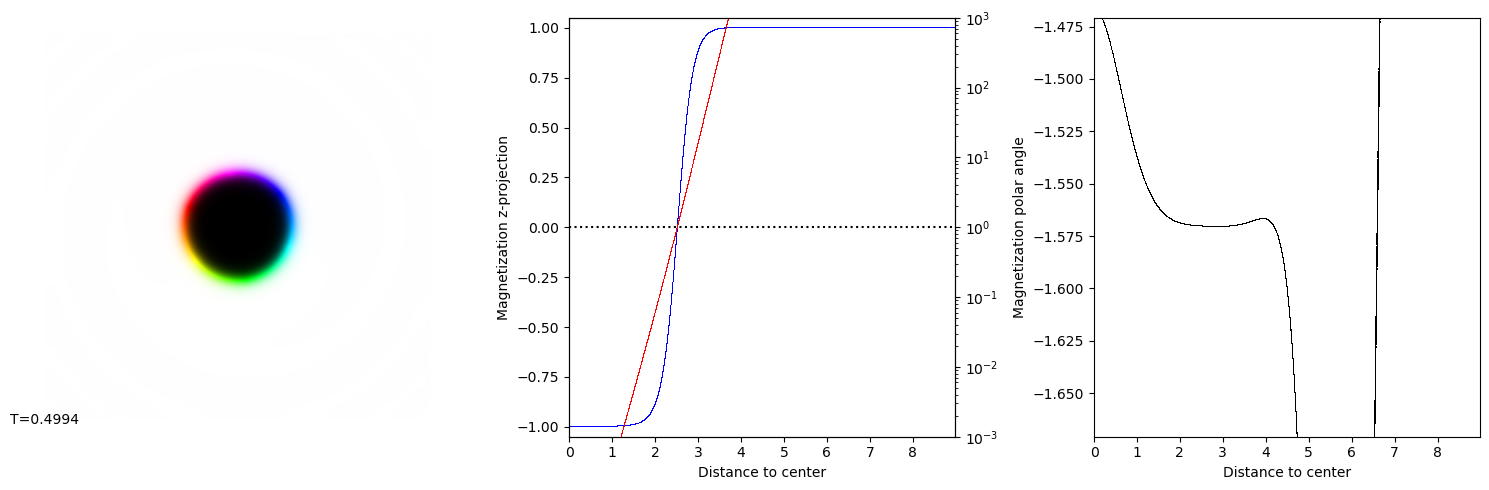

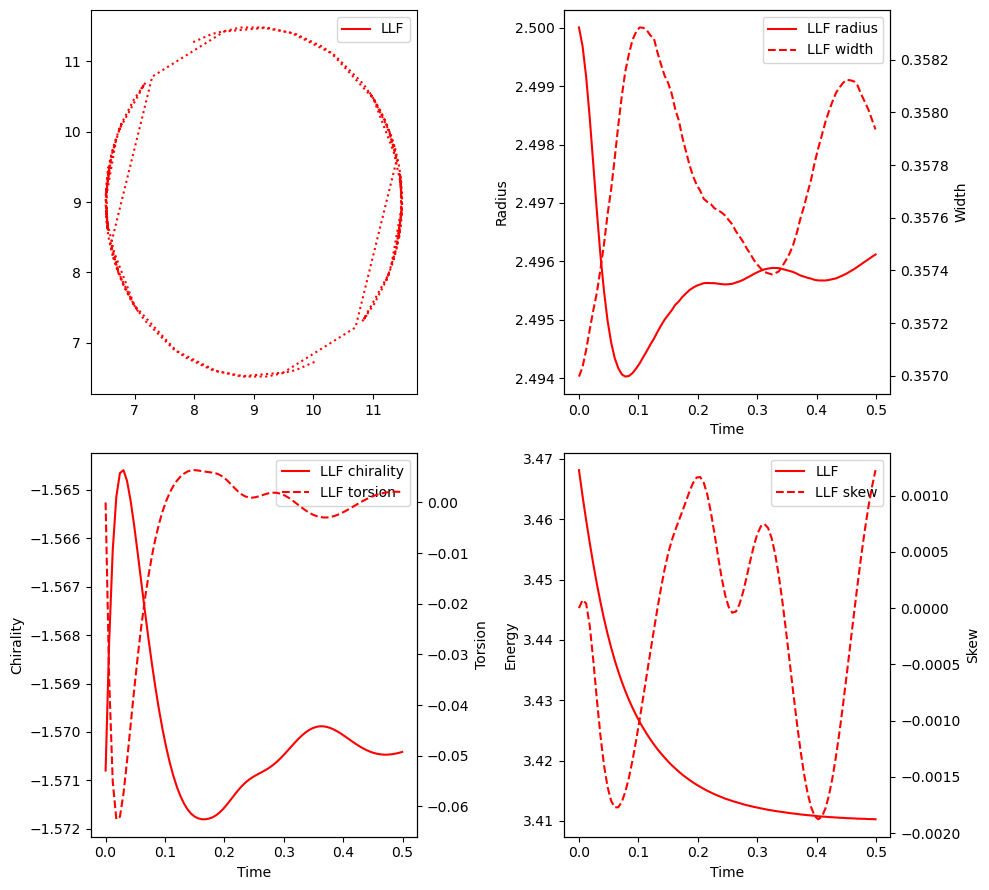

In [8]:
system = mg.System(
    Lx=18, Ly=18, D=3.5, K=7.7, H=0,
    eta=0.2, jx=0, beta=0.,
)
print(system)

comp = mg.Computer2(system)
xy = comp.coordinates(900, 900)

folder =  f'../tmp8/rlx_Lx{system.Lx}_D{system.D}_K{system.K}_H{system.H}_eta{system.eta}_sx{xy.shape[1]}'
os.makedirs(folder, exist_ok=True)

# Full ansatz
a = mg.Ansatz(ansatz, computer=comp, args=[xy])
p0 = jnp.array([system.Lx/2,system.Ly/2,2.5,0.357,-np.pi/2,0.,0.])


filename = f'{folder}/stbl'
print(f"Saving to {filename}.npz")
n0 = a(p0)
n1 = mg.run_llg_dynamics(filename, n0=n0, comp=comp, 
    fit=lambda n: mg.fit_params(n, xy), 
    plot=lambda n, **kwargs: mg.analyze_geometry(n, xy, **kwargs),
    simulation_period=1., dt=0.00003, report_time=0.006, rep=2,
)
    
# analyze_geometry(n1, xy)

data, _ = mg.plot_result(f"{filename}.npz")
plt.savefig(f"{filename}.summary.pdf")
plt.show()


In [ ]:
comp.system = system = mg.System(
    Lx=18, Ly=18, D=3.5, K=7.7, H=0.1,
    eta=0.2, jx=0, beta=0.,
)
print(comp.system)
  
filename = f'{folder}/aply'
print(f"Saving to {filename}.npz")
n2 = mg.run_llg_dynamics(filename, n0=n1, comp=comp, 
    fit=lambda n: mg.fit_params(n, xy), 
    plot=lambda n, **kwargs: mg.analyze_geometry(n, xy, **kwargs),
    simulation_period=20., dt=0.00005, report_time=0.02
)

# analyze_geometry(n2, xy)

data, _ = mg.plot_result(f"{filename}.npz")
plt.savefig(f"{filename}.summary.pdf")
plt.show()


In [ ]:
comp.system = system = mg.System(
    Lx=18, Ly=18, D=3.5, K=7.7, H=0.,
    eta=0.2, jx=0, beta=0.,
)
print(comp.system)

data = np.load(f'{folder}/aply.npz')
n2 = data['n_llg']

filename = f'{folder}/relx'
print(f"Saving to {filename}.npz")
n3 = mg.run_llg_dynamics(filename, n0=n2, comp=comp, 
    fit=lambda n: mg.fit_params(n, xy), 
    plot=lambda n, **kwargs: mg.analyze_geometry(n, xy, **kwargs),
    simulation_period=40., dt=0.0002, report_time=0.02
)

# analyze_geometry(n3, xy)

data, _ = mg.plot_result(f"{filename}.npz")
plt.savefig(f"{filename}.summary.pdf")
plt.show()


In [ ]:
filename = f'{folder}/stbl'
# filename = f'{folder}/aply'


data, _ = mg.plot_result(f"{filename}.npz")
plt.savefig(f"{filename}.summary.pdf")
plt.show()

# Current

In [ ]:
system = mg.System(
    Lx=18, Ly=18, D=3.5, K=7.7, H=0,
    eta=0.2, jx=0, beta=0.,
)
print(system)

comp = mg.Computer2(system)
xy = comp.coordinates(300, 300)

folder =  f'../tmp6/rlx_Lx{system.Lx}_D{system.D}_K{system.K}_H{system.H}_eta{system.eta}_sx{xy.shape[1]}'
os.makedirs(folder, exist_ok=True)


# Full ansatz
a = mg.Ansatz(ansatz, argnum=7, computer=comp, args=[xy])
p0 = jnp.array([system.Lx-4,system.Ly/2,2.5,0.357,-np.pi/2,0.,0.])
n0 = a(p0)

filename = f'{folder}/cur0'
print(f"Saving to {filename}.npz")
n1 = mg.run_llg_dynamics(filename, n0=n0, comp=comp, 
    fit=lambda n: mg.fit_params(n, xy), 
    plot=lambda n, **kwargs: mg.analyze_geometry(n, xy, **kwargs),
    simulation_period=3., dt=0.0002, report_time=0.02
)

# analyze_geometry(n3, xy)

data, _ = plot_result(f"{filename}.npz")
plt.savefig(f"{filename}.summary.pdf")
plt.show()


In [ ]:
comp.system = system = mg.System(
    Lx=18, Ly=18, D=3.5, K=7.7, H=0.,
    eta=0.1, jx=1.0, beta=0.0,
)
print(comp.system)

data = np.load(f'{folder}/cur0.npz')
n1 = data['n_llg']

filename = f'{folder}/cur1_eta{system.eta}_beta{system.beta}'
print(f"Saving to {filename}.npz")
n2 = mg.run_llg_dynamics(filename, n0=n1, comp=comp, 
    fit=lambda n: mg.fit_params(n, xy), 
    plot=lambda n, **kwargs: mg.analyze_geometry(n, xy, var=None, **kwargs),
    simulation_period=10., dt=0.0002, report_time=0.02
)

# analyze_geometry(n3, xy)

data, _ = mg.plot_result(f"{filename}.npz")
plt.savefig(f"{filename}.summary.pdf")
plt.show()


# Thiele

In [3]:
# def run_thiele_dynamics(
#         state, ansatz:mg.Ansatz, 
#         simulation_period=0.1, dt=0.0002, report_time=0.02,
#         decode=lambda p:p,
#         ):
#     state = jnp.array(state)
#     a = ansatz
#     comp = a.computer
#     # Initial state
#     t = 0.
#     last_report = t
    
#     # Init data collection
#     p = decode(state)
#     hist = [list(p)]    
#     energy = [comp.energy(a(state))]
#     time = [t]

#     # Init graphics
#     with Progress(transient=True) as progress:
#         task = progress.add_task("Working", total=simulation_period)

#         try:
#             while t<=simulation_period:
#                 state = a.time_increment(state, dt=dt)

#                 t += dt
#                 if t>last_report+report_time:
#                     last_report = t

#                     n = a(state)
#                     e = comp.energy(n)

#                     progress.update(task, completed=t)

#                     time.append( t )
#                     p = decode(state)
#                     hist.append( list(p) )
#                     energy.append( e )
#         except KeyboardInterrupt:
#             pass
#     return np.asarray(time), np.asarray(hist), np.asarray(energy)


# def execute_experiment(filename, ansatz_fn, fit,  
#                        save_state=lambda _:[], encode=lambda p:p, decode=lambda p:p, 
#                        name=None, dt=0.0002, thiele=True):
#     if name is None:
#         name = f'thiele'
#     print(f"Saving to {name}")
#     # Read file creare by `run_llg_dynamics`
#     data = np.load(f"{filename}.npz", allow_pickle=True)
#     time = data['time']
#     n0 = data['n0']
#     # Recreate system
#     system = mg.System(**data['system'][()])
#     print(f"Loaded system {system}")
#     print(f"Data shape {n0.shape}")    
#     print(f"Read parameters {data['hist_llg'][0]}")    
#     comp = mg.Computer2(system)
#     xy = comp.coordinates(*n0.shape[1:3])
#     p0 = np.array(fit(n0,xy))
#     print(f"Computed parameters {p0}")   
#     e0 = encode(p0)
#     print(f"Encoded parameters {e0}")
#     d0 = decode(e0)
#     print(f"Decoded parameters {d0}")
#     e1 = encode(d0)
#     print(f"Re-encoded parameters {e1}")
#     assert np.max(np.abs(np.array(e1)-np.array(e0)))<1e-6, f"Decode/encode do not match {e0=} {e1=}"
#     argnum = len(e0)
#     print(f"Number of arguments {argnum}")      
#     a = (mg.Thiele if thiele else mg.CDyn)(ansatz_fn, computer=comp, args=[xy]+save_state(p0))

#     time1, hist, energy = run_thiele_dynamics(
#         state=e0, ansatz=a, 
#         simulation_period=np.max(time), 
#         dt=dt, 
#         report_time=time[1]-time[0]-dt,
#         decode=decode,
#         )
    
#     res = {
#         'system': system.__dict__, 
#         'time': time1,
#         f'hist_{name}': hist, 
#         f'energy_{name}': energy,
#         }
# #     for k, v in res.items():
# #         print(f"{k}: {v.shape}")
    
#     np.savez(f'{filename}_{name}.npz', **res)    
#     return hist[-1]
 
def check_energy(filename, ansatz_fn, fit, argnum=6):
    data = np.load(f"{filename}.npz", allow_pickle=True)
    time = data['time']
    energy = data['energy']    
    n0 = data['n0']
    # Recreate system
    system = mg.System(**data['system'][()])
    print(f"Loaded system {system}")
    print(f"Data shape {n0.shape}")
    hist = data['hist_llg']
    print(f"Read parameters {hist[0]}")
    comp = mg.Computer2(system)
    xy = comp.coordinates(*n0.shape[1:3])
    p0 = fit(n0,xy)
    print(f"Computed parameters {p0}")    
    a = mg.Ansatz(ansatz_fn, argnum=argnum, computer=comp, args=list(p0[argnum:])+[xy])
    n1 = a(p0[:argnum])
    print(f"Ansatz interpolation error {np.max(np.abs(n1-n0))}")
    N = hist.shape[0]
    parerr = np.zeros(N)
    energy1 = np.zeros(N)
    for k in range(N):
        p0 = hist[k,:argnum]
        n = a(p0)
        p1 = fit(n)
        parerr[k] = np.max(np.abs(p0-p1[:argnum]))
        energy1[k] = comp.energy(n)
    fig, ax = plt.subplots(figsize=(5,5))
    bx = ax.twinx()
    ax.semilogy(time, parerr)
    ax.set_xlabel('Time')
    ax.set_ylabel('Parameters error')
    bx.plot(time, energy, '-r', label='Exact')
    bx.plot(time, energy1, '-k', label='Ansatz')    
    bx.set_ylabel('Energy')    
    plt.show()
    
def show(filename, name):
    data0, figax = mg.plot_result(f"{filename}.npz")
    data1, figax = mg.plot_result(f"{filename}_{name}.npz", figax=figax, suffix=name, label=f'Thiele', color='k')
    plt.savefig(f"{filename}.summary_{name}.pdf")
    plt.show()


In [4]:

def exp_rr(filename, name='rr'): # radius, width, chirality
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy, radius0, width0: # radius:
             ansatz([9., 9., e[0], e[0]/radius0*width0, -np.pi/2, 0, 0], xy),            
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[p[2],p[3]],
        encode=lambda p: [p[2]],
        decode=lambda e: [9,9,e[0],np.nan,-np.pi/2,0,0],             
    ), name

#################################

def exp_r(filename, name='r'): # radius, width, chirality
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy, width0: # radius
            ansatz([9., 9., e[0], width0, -np.pi/2, 0, 0], xy), 
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[p[3]],
        encode=lambda p: [p[2]],
        decode=lambda e: [9,9,e[0],np.nan,-np.pi/2,0,0],             
    ), name

#################################

def exp_rw(filename, name='rw'): # radius, width, chirality
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy: # radius, width
            ansatz([9., 9., e[0], e[1], -np.pi/2, 0, 0], xy), 
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[],
        encode=lambda p: [p[2],p[3]],
        decode=lambda e: [9,9,e[0],e[1],-np.pi/2,0,0],             
    ), name

#################################

def exp_rwc(filename, name='rwc'): # radius, width, chirality
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy: # radius, width, chirality
            ansatz([9., 9., e[0], e[1], e[2], 0, 0], xy), 
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[],
        encode=lambda p: [p[2],p[3],p[4]],
        decode=lambda e: [9,9,e[0],e[1],e[2],0,0],             
    ), name

#################################

def exp_rsc(filename, name='rsc'): # radius, scale, chirality
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy: # radius, scale, chirality
            ansatz_s([9., 9., e[0], e[1], e[2], 0, 0], xy), 
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[],
        encode=lambda p: [p[2],1/p[3],p[4]],
        decode=lambda e: [9,9,e[0],1/e[1],e[2],0,0],             
    ), name


#################################

def exp_rrc(filename, name='rrc'): # radius, width, chirality
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy, radius0, scale0: # radius, chirality 
                ansatz_s([9., 9., e[0], scale0*radius0/e[0], e[1], 0, 0], xy), 
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[p[2],1/p[3]],
        encode=lambda p: [p[2],p[4]],
        decode=lambda e: [9,9,e[0],np.nan,e[1],0,0],             
    ), name


#################################

def exp_rc(filename, name='rc'): # radius, width, chirality
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy, scale0: # radius, chirality 
                ansatz_s([9., 9., e[0], scale0, e[1], 0, 0], xy), 
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[1/p[3]],
        encode=lambda p: [p[2],p[4]],
        decode=lambda e: [9,9,e[0],np.nan,e[1],0,0],             
    ), name

#################################

def exp_xyrc(filename, name='xyrc'): # radius, width, chirality
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy, width0: # x, y, radius, chirality 
                ansatz([e[0], e[1], e[2], width0, e[3], 0, 0], xy), 
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[p[3]],
        encode=lambda p: [p[0],p[1],p[2],p[4]],
        decode=lambda e: [e[0],e[1],e[2],np.nan,e[3],0,0],    
#         thiele=False,
    ), name

#################################

def exp_xyrwc(filename, name='xyrwc'): 
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy: # x, y, radius, chirality 
                ansatz([e[0], e[1], e[2], e[3], e[4], 0, 0], xy), 
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[],
        encode=lambda p: [p[0],p[1],p[2],p[3],p[4]],
        decode=lambda e: [e[0],e[1],e[2],e[3],e[4],0,0],    
#         thiele=False,
    ), name

#################################

def exp_xy(filename, name='xy'): # radius, width, chirality
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy, radius0, width0, chirality0: # x, y 
                ansatz([e[0], e[1], radius0, width0, chirality0, 0, 0], xy), 
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[p[2],p[3],p[4]],
        encode=lambda p: [p[0],p[1]],
        decode=lambda e: [e[0],e[1],np.nan,np.nan,np.nan,0,0],             
    ), name

#################################

def exp_all(filename, name='all'): # radius, width, chirality
    return mg.execute_experiment(filename, 
        ansatz_fn=lambda e, xy: # x, y 
                ansatz(e, xy), 
        name=name,
        fit=mg.fit_params,
        dt=0.02,
        save_state=lambda p:[],
        encode=lambda p: p,
        decode=lambda e: e,             
    ), name




In [ ]:
def run(filename):
    _, name = exp_xyrc(filename)
    show(filename, name)


folder = '../tmp6/rlx_Lx18_D3.5_K7.7_H0_eta0.2_sx300/'

run(f"{folder}/stbl")
# run(f"{folder}/aply")
# run(f"{folder}/relx")

# run(f"{folder}/cur1")
# run(f"{folder}/cur1_eta0.1_beta0.1")
# run(f"{folder}/cur1_eta0.1_beta0.0")
# run(f"{folder}/cur1_j1.0_beta0.2")



Saving to xyrc
Loaded system System(A=1, J=1, D=3.5, H=0, K=7.7, Lx=18, Ly=18, Ms=1, gamma=1, eta=0.2, beta=0.0, jx=0, jy=0.0)
Data shape (3, 300, 300, 1)
Read parameters [ 9.00000000e+00  9.00000000e+00  2.50000283e+00  3.56997173e-01
 -1.57079633e+00  1.80931659e-15 -6.66133815e-16]
Computed parameters [ 9.00000000e+00  9.00000000e+00  2.50000283e+00  3.56997173e-01
 -1.57079633e+00  1.80931659e-15 -6.66133815e-16]
Encoded parameters [9.0, 9.0, 2.500002828988485, -1.5707963267948963]
Decoded parameters [9.0, 9.0, 2.500002828988485, nan, -1.5707963267948963, 0, 0]
Re-encoded parameters [9.0, 9.0, 2.500002828988485, -1.5707963267948963]
Number of arguments 4


Output()

Initial LLF    [ 9.00000000e+00  9.00000000e+00  2.50000283e+00  3.56997173e-01
 -1.57079633e+00  1.80931659e-15 -6.66133815e-16]
Final LLF      [ 8.99999999e+00  9.00000002e+00  2.49819944e+00  3.57702747e-01
 -1.57000766e+00 -1.99820363e-04  6.07920485e-04]
Initial Thiele    [ 9.          9.          2.50000283         nan -1.57079633  0.
  0.        ]
Final Thiele      [ 8.99999995  8.99999993  2.50158326         nan -1.57049481  0.
  0.        ]


In [7]:
folder = '../tmp6/rlx_Lx18_D3.5_K7.7_H0_eta0.2_sx300/'
# folder = '../tmp6/rlx_Lx18_D3.5_K7.7_H0_eta0.2_sx300/'

filename = f"{folder}/stbl"
# filename = f"{folder}/aply"
# filename = f"{folder}/relx"
# filename = f"{folder}/cur1"
# filename = f"{folder}/cur1_beta0.1"
# filename = f"{folder}/cur1_eta0.1_beta0.1"

# data = np.load(f"{filename}_rc.npz")
# hist=data['hist_rc']   
# print(hist)
# fig, ax = plt.subplots()
# plot_param_trajectory(hist, ax=ax)


show(filename, 'xyrc')


Initial LLF    [ 9.00000000e+00  9.00000000e+00  2.50000283e+00  3.56997173e-01
 -1.57079633e+00  1.80931659e-15 -6.66133815e-16]
Final LLF      [ 8.99999999e+00  9.00000002e+00  2.49819944e+00  3.57702747e-01
 -1.57000766e+00 -1.99820363e-04  6.07920485e-04]
Initial Thiele    [ 9.          9.          2.50000283         nan -1.57079633  0.
  0.        ]
Final Thiele      [ 8.99999995  8.99999993  2.50158326         nan -1.57049481  0.
  0.        ]


In [ ]:
folder = '../tmp6/rlx_Lx18_D3.5_K7.7_H0_eta0.2_sx300/'
filename = f"{folder}/aply"
data = np.load(f"{filename}_rwc.npz")
hist=data['hist_rwc']   
# print(hist)
fig, ax = plt.subplots()
# plot_param_trajectory(hist, ax=ax)
r, w = hist[:,2], hist[:,3]
ax.plot(r, w, '-r')
ax.plot(r, w[0]*r/r[0], '-k')